In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


## Import một số thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow as tf
#from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Đọc file csv
df = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.shape

(35887, 3)

### Kiểm tra số lượng ảnh mờ, nhiễu trong dataset

In [5]:
df['pixels_array'] = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=np.float32))
df['pixel_mean'] = df['pixels_array'].apply(np.mean)
df['pixel_std'] = df['pixels_array'].apply(np.std)

In [6]:
# Mờ = mean < 40 và std < 15
blurred_df = df[(df['pixel_mean'] < 40) & (df['pixel_std'] < 15)]
print(f"Số lượng ảnh mờ: {len(blurred_df)}")


Số lượng ảnh mờ: 16


In [7]:
# Nhiễu = std > 70
noisy_df = df[df['pixel_std'] > 70]
print(f"Số lượng ảnh nghi nhiễu: {len(noisy_df)}")


Số lượng ảnh nghi nhiễu: 4486


## Xóa ảnh mờ và làm mượt ảnh bị nhiễu

In [8]:
import cv2
import numpy as np
blurred_idx = blurred_df.index  # danh sách index ảnh mờ
noisy_idx = noisy_df.index      # danh sách index ảnh nhiễu
def process_pixel_array(pixels_array, idx, blurred_idx, noisy_idx):
    img = np.array(pixels_array).reshape(48, 48).astype(np.uint8)

    if idx in blurred_idx:
        return None  # Xoá ảnh mờ

    if idx in noisy_idx:
        img = cv2.medianBlur(img, 3)  # Làm mượt ảnh nghi nhiễu

    img = cv2.resize(img, (160, 160), interpolation=cv2.INTER_CUBIC)
    img_rgb = np.stack([img]*3, axis=-1)
    return img_rgb


In [9]:
clean_images = []
clean_labels = []

for idx, row in df.iterrows():
    img = process_pixel_array(row['pixels_array'], idx, blurred_idx, noisy_idx)
    if img is not None:
        clean_images.append(img)
        clean_labels.append(row['emotion'])

## Kiểm tra các ảnh đã xử lý hay chưa

In [10]:
print(f"Tổng số ảnh ban đầu: {len(df)}")

Tổng số ảnh ban đầu: 35887


In [11]:
print(f"Tổng số ảnh sau xử lý: {len(clean_images)}")

Tổng số ảnh sau xử lý: 35871


In [12]:
print(f"Số ảnh mờ bị loại: {len(blurred_idx)}")
print(f"Số ảnh nhiễu được làm mượt: {len(noisy_idx)}")

Số ảnh mờ bị loại: 16
Số ảnh nhiễu được làm mượt: 4486


## Kiểm tra các ảnh bị lỗi

In [13]:
# Thống kê thêm
df['pixel_min'] = df['pixels_array'].apply(np.min)
df['pixel_max'] = df['pixels_array'].apply(np.max)

# Đặt điều kiện loại ảnh lỗi
def is_corrupted(row):
    mean = row['pixel_mean']
    std = row['pixel_std']
    min_val = row['pixel_min']
    max_val = row['pixel_max']
    return (
        mean < 10 or
        mean > 245 or
        std < 5 or
        (max_val - min_val) < 20 or
        max_val < 30 or
        min_val > 225
    )

df['corrupted'] = df.apply(is_corrupted, axis=1)

# Tách ảnh sạch và lỗi
corrupted_df = df[df['corrupted']]
clean_df = df[~df['corrupted']]

print(f"Số ảnh lỗi bị loại bỏ: {len(corrupted_df)}")
print(f"Số ảnh còn lại sau khi loại: {len(clean_df)}")


Số ảnh lỗi bị loại bỏ: 20
Số ảnh còn lại sau khi loại: 35867


## Gán nhãn dữ liệu

In [14]:
label_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4:'sadness',
                5: 'surprise', 6: 'neutral'}

## kiểm tra số ảnh bị gán nhãn sai

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def inspect_all_classes(df, label_to_text, n_samples=10, outlier_std_thresh=2):
    from scipy.stats import zscore

    # Tính z-score để tìm outlier
    df['z_mean'] = df.groupby('emotion')['pixel_mean'].transform(zscore)
    df['z_std'] = df.groupby('emotion')['pixel_std'].transform(zscore)

    classes = sorted(df['emotion'].unique())

    for cls in classes:
        print(f"\n Class {cls} - {label_to_text[cls]}")

        # Hiển thị ảnh ngẫu nhiên trong class
        samples = df[df['emotion'] == cls].sample(n_samples, random_state=42)
        print(f" {n_samples} ảnh ngẫu nhiên:")
        for _, row in samples.iterrows():
            img = np.array(row['pixels_array']).reshape(48, 48)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(label_to_text[cls])
            plt.show()

        # Hiển thị các ảnh nghi là outlier theo pixel
        outliers = df[(df['emotion'] == cls) & ((np.abs(df['z_mean']) > outlier_std_thresh) | (np.abs(df['z_std']) > outlier_std_thresh))]
        print(f" Ảnh nghi outlier: {len(outliers)}")
        for _, row in outliers.head(n_samples).iterrows():
            img = np.array(row['pixels_array']).reshape(48, 48)
            plt.imshow(img, cmap='gray')



 Class 0 - Anger
 5 ảnh ngẫu nhiên:


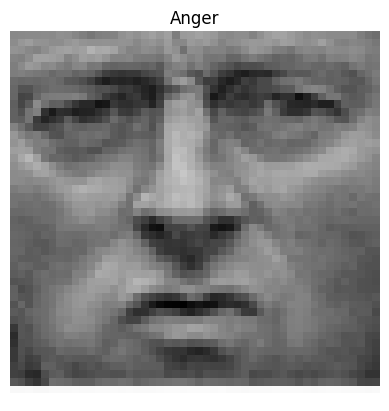

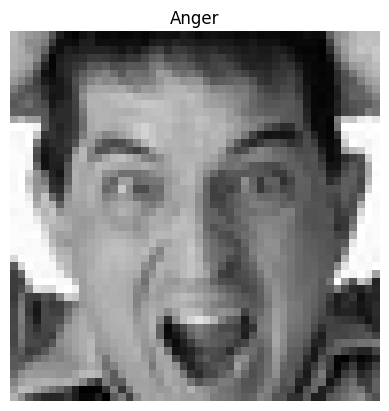

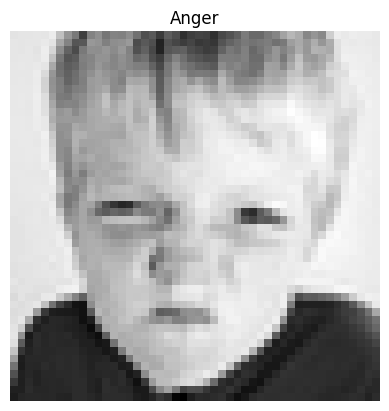

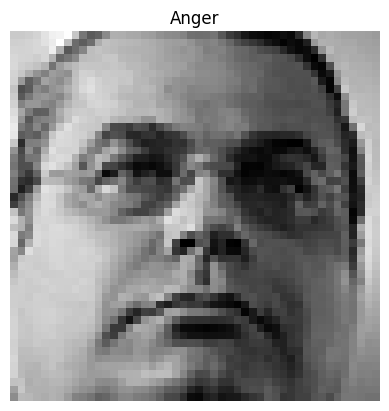

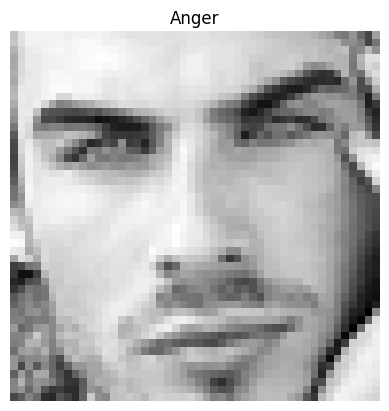

 Ảnh nghi outlier: 397

 Class 1 - Disgust
 5 ảnh ngẫu nhiên:


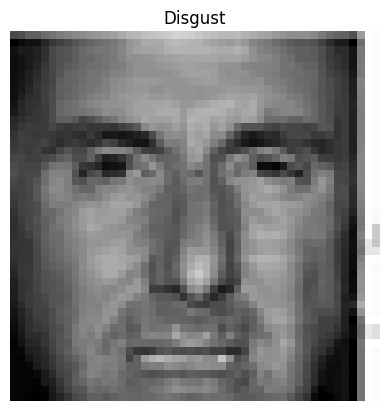

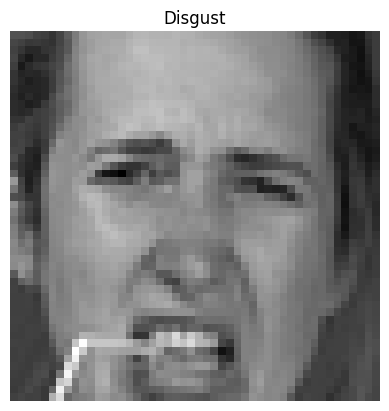

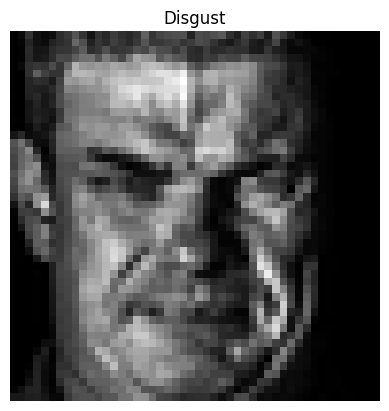

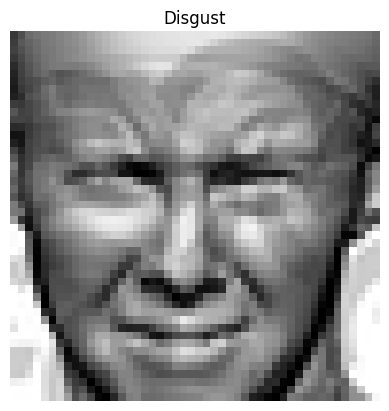

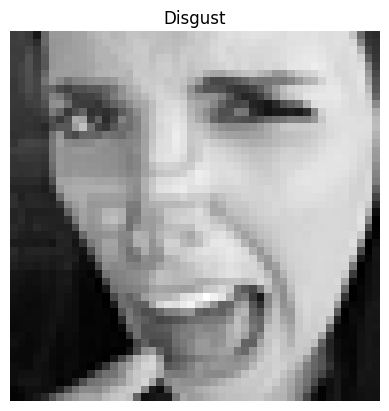

 Ảnh nghi outlier: 34

 Class 2 - Fear
 5 ảnh ngẫu nhiên:


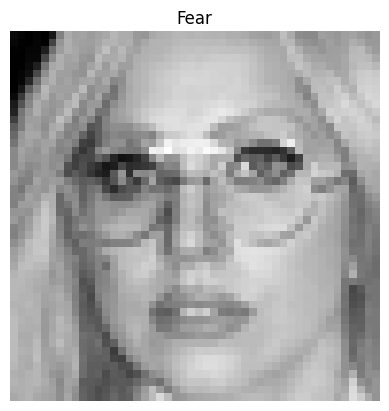

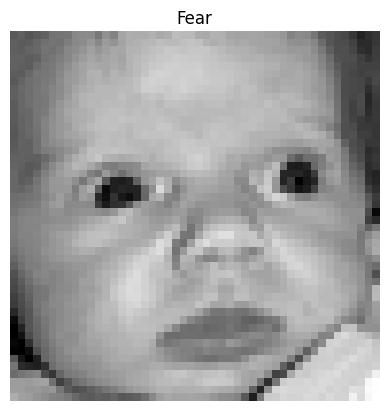

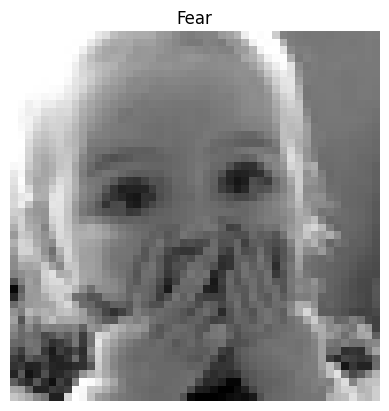

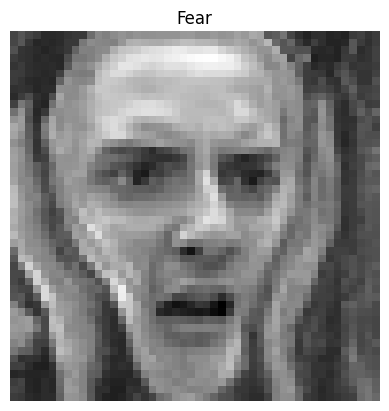

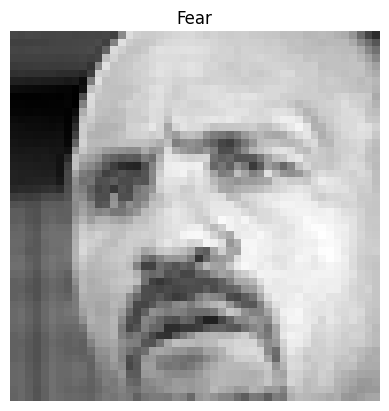

 Ảnh nghi outlier: 378

 Class 3 - Happiness
 5 ảnh ngẫu nhiên:


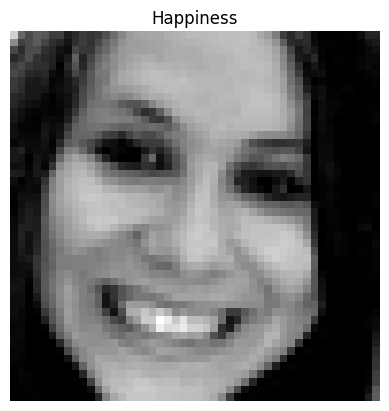

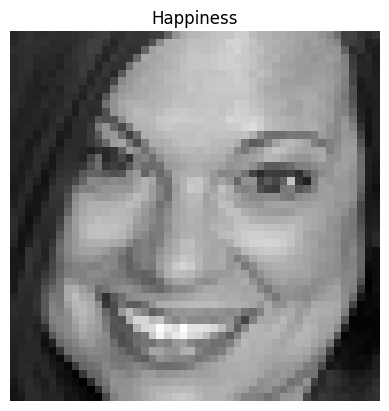

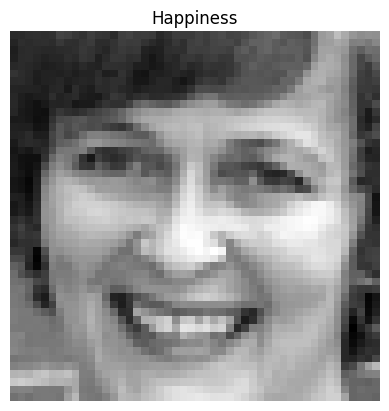

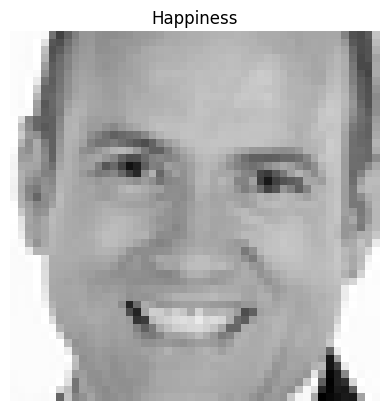

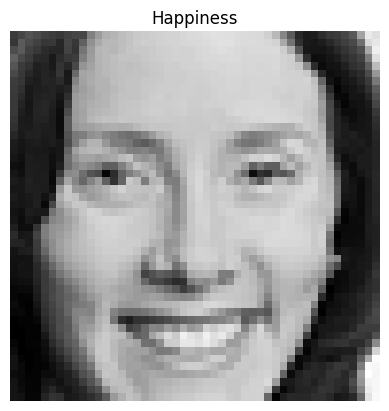

 Ảnh nghi outlier: 722

 Class 4 - sadness
 5 ảnh ngẫu nhiên:


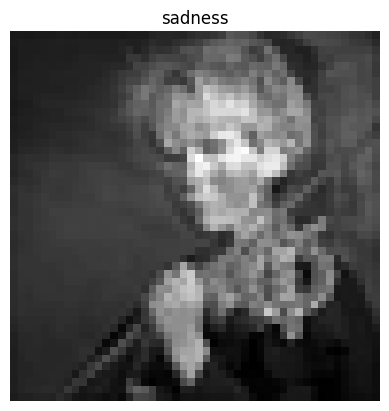

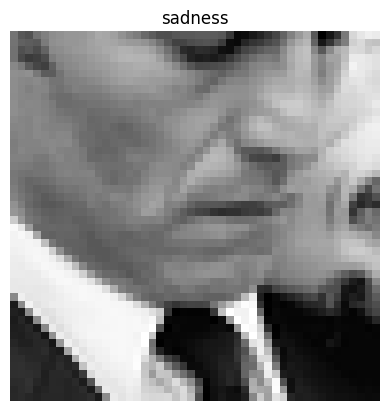

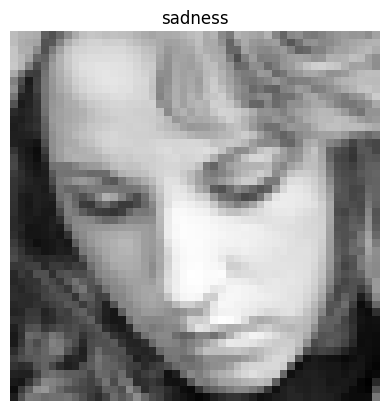

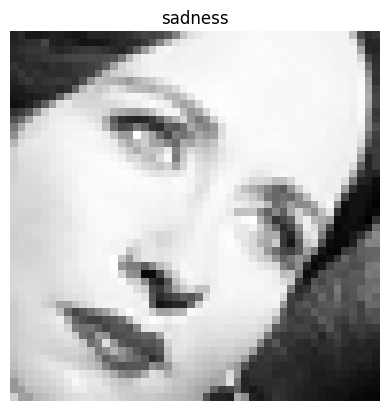

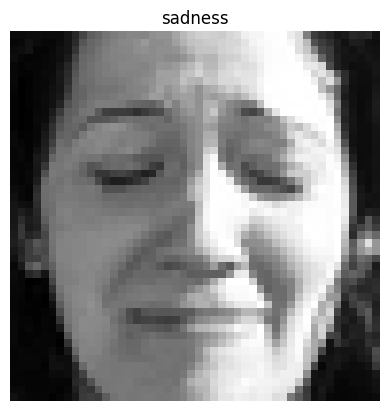

 Ảnh nghi outlier: 502

 Class 5 - surprise
 5 ảnh ngẫu nhiên:


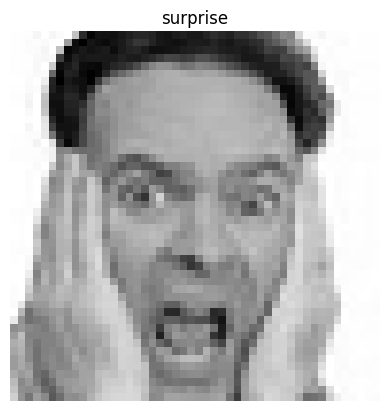

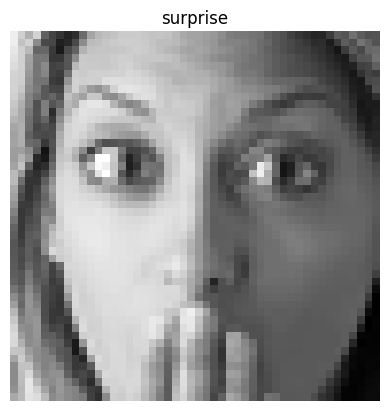

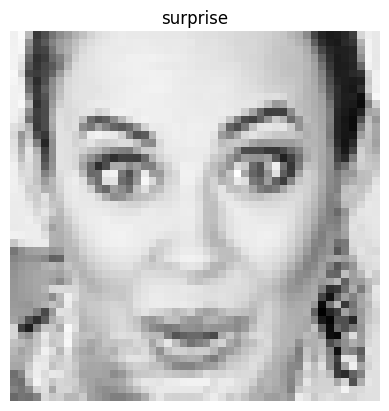

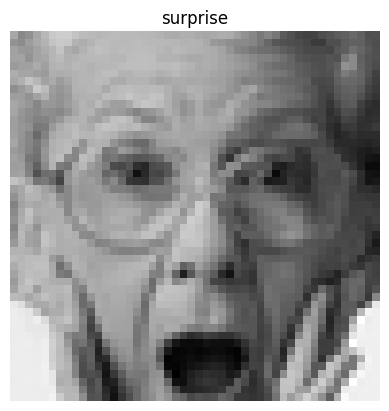

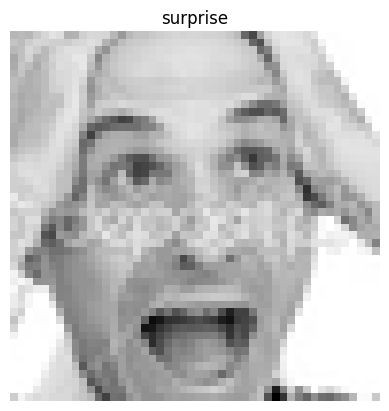

 Ảnh nghi outlier: 301

 Class 6 - neutral
 5 ảnh ngẫu nhiên:


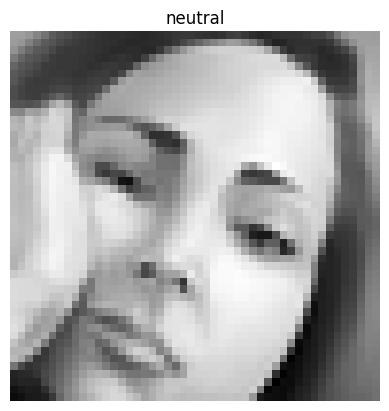

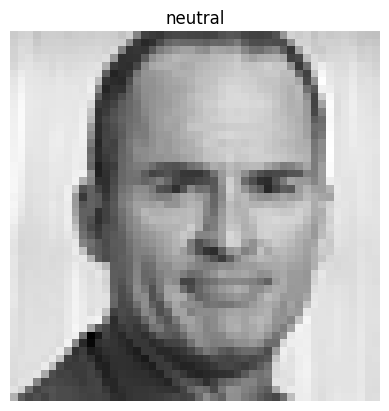

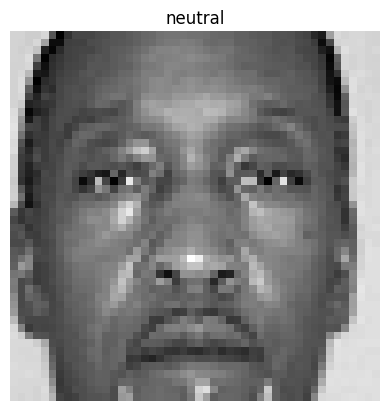

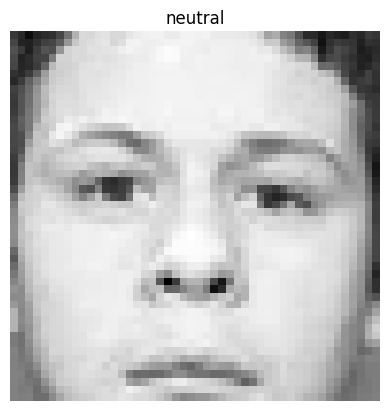

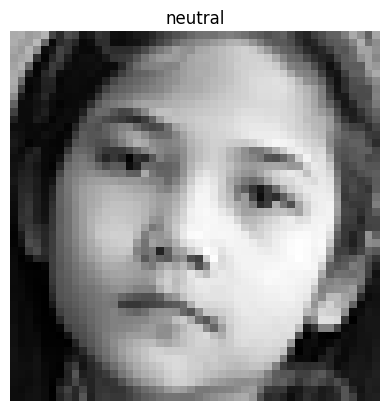

 Ảnh nghi outlier: 478


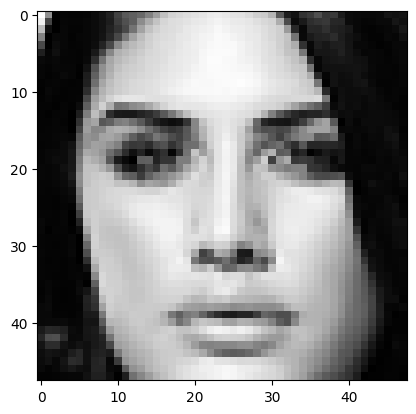

In [16]:
inspect_all_classes(df, label_to_text, n_samples=5, outlier_std_thresh=2)

## Loại bỏ outlier

In [17]:
from scipy.stats import zscore

# Tính z-score theo từng class
df['z_mean'] = df.groupby('emotion')['pixel_mean'].transform(zscore)
df['z_std'] = df.groupby('emotion')['pixel_std'].transform(zscore)


In [18]:
# Tiêu chí loại bỏ: |z-score của pixel_mean| > 2 (hoặc 3)
#hoặc |z-score của pixel_std| > 2 (hoặc 3)
threshold = 2  # hoặc 3 nếu bạn muốn giữ lại nhiều hơn

# Xác định chỉ số outlier
outlier_idx = df[(df['z_mean'].abs() > threshold) | (df['z_std'].abs() > threshold)].index

# Tạo DataFrame sạch
df_clean = df.drop(index=outlier_idx)

print(f"Số ảnh bị loại vì outlier: {len(outlier_idx)}")
print(f"Số ảnh còn lại sau khi lọc: {len(df_clean)}")


Số ảnh bị loại vì outlier: 2812
Số ảnh còn lại sau khi lọc: 33075


## Hiển thị ảnh trước khi training

In [19]:
import matplotlib.pyplot as plt
import numpy as np
# Hiển thị ảnh sau khi xử lý data
def show_clean_samples(df_clean, label_to_text, n_samples=5):
    fig = plt.figure(figsize=(18, 18))
    k = 1
    num_classes = df_clean['emotion'].nunique()

    for label in sorted(df_clean['emotion'].unique()):
        samples = df_clean[df_clean['emotion'] == label].sample(n_samples, random_state=42)

        for _, row in samples.iterrows():
            pixels = np.array(row['pixels_array']).reshape(48, 48)  # giả sử bạn đã có pixels_array
            ax = plt.subplot(num_classes, n_samples, k)
            ax.imshow(pixels, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(label_to_text[label])
            k += 1

    plt.tight_layout()
    plt.show()


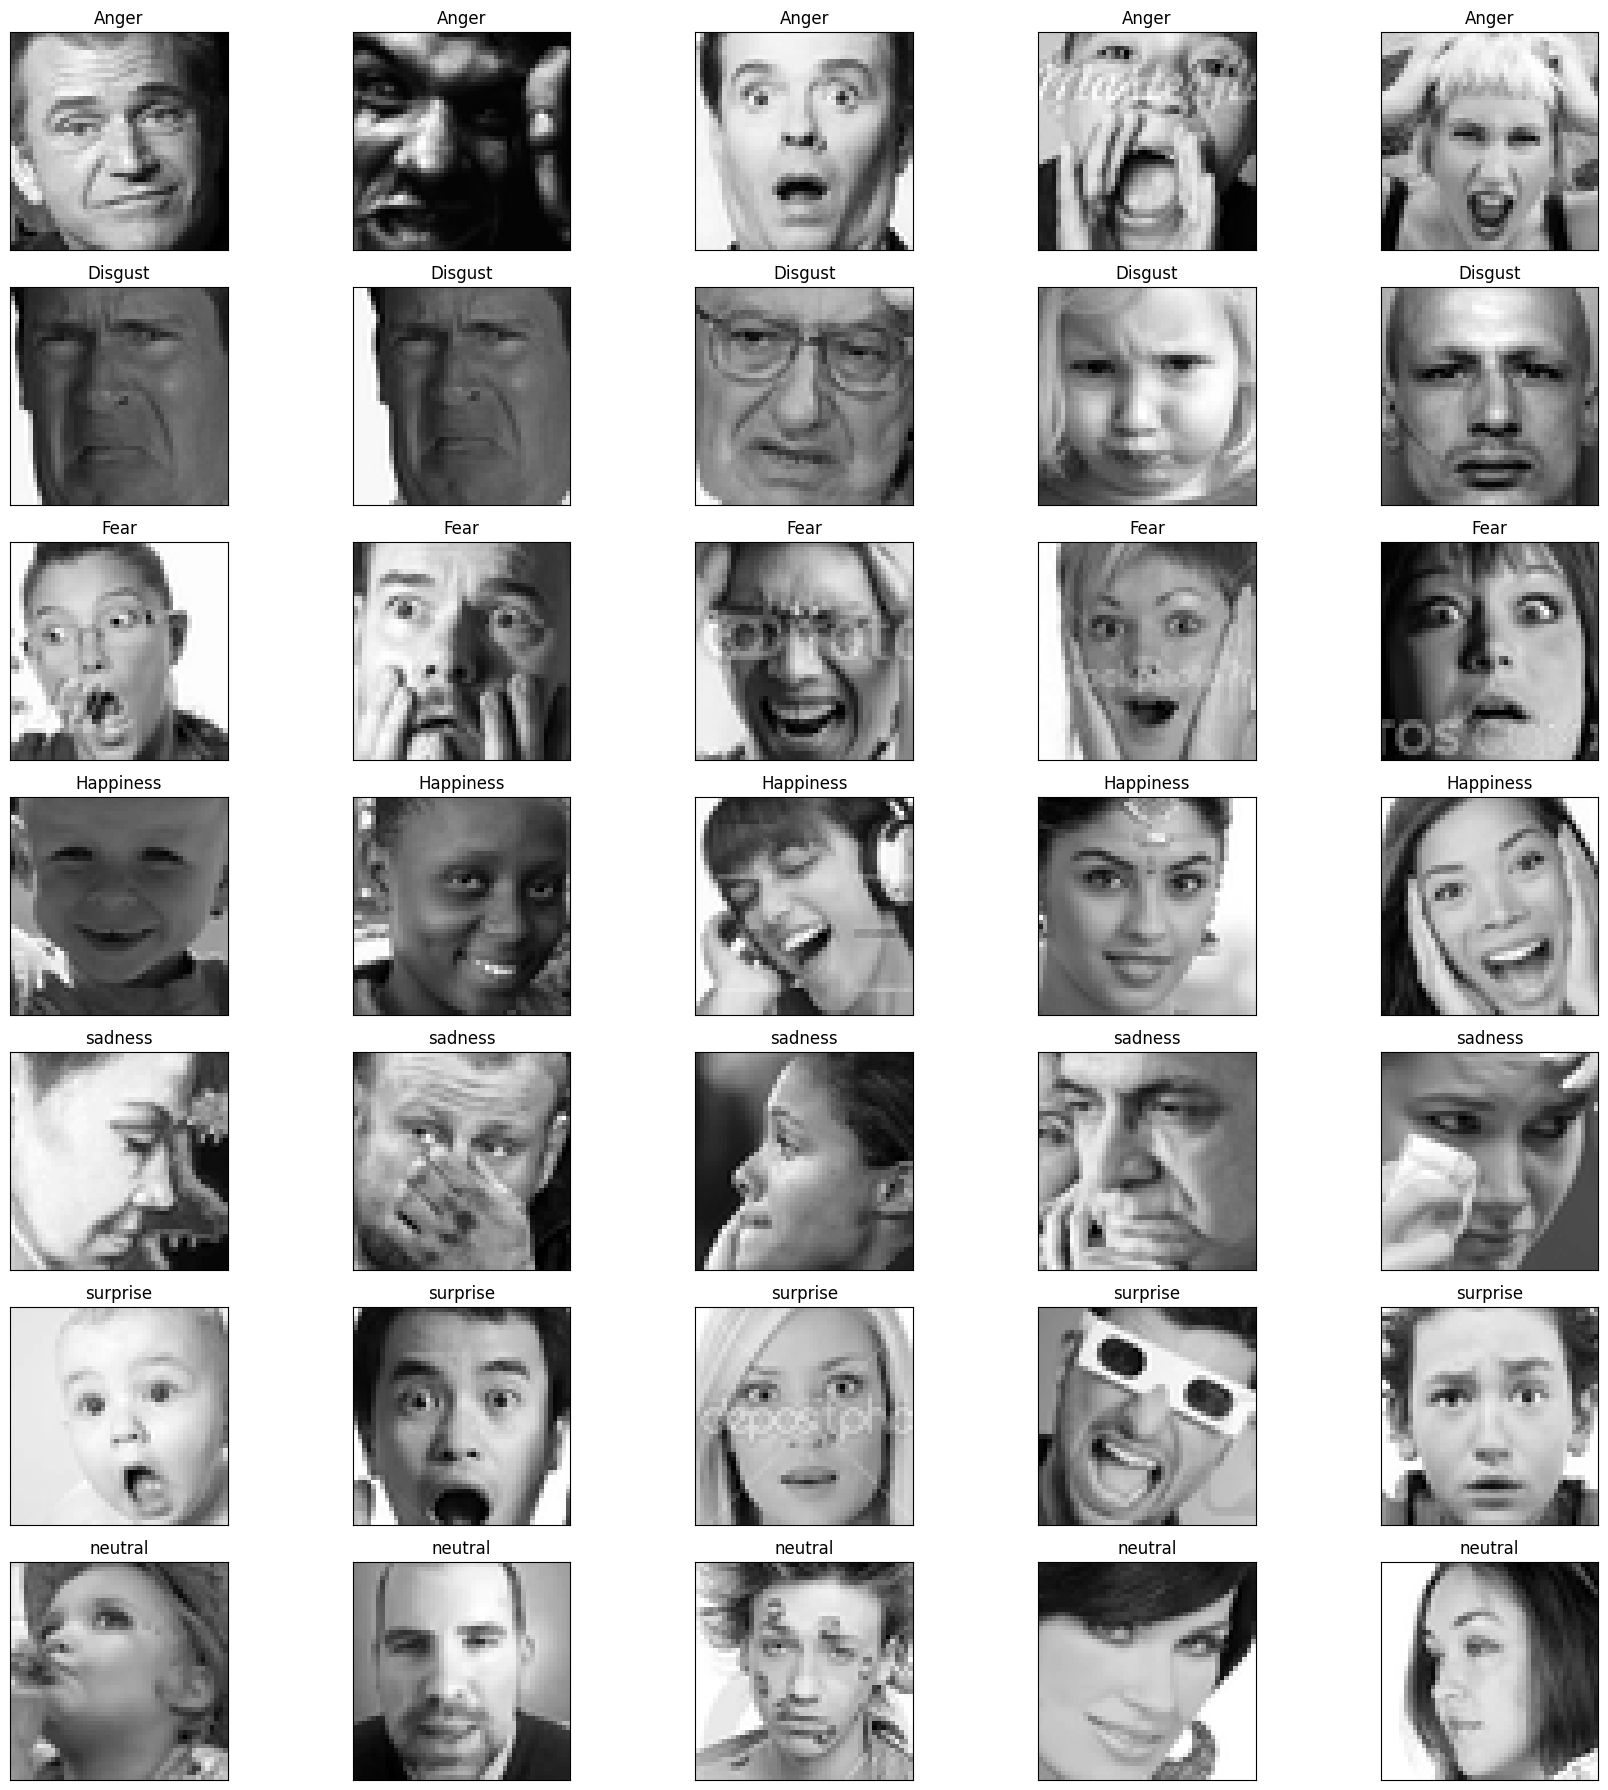

In [20]:
show_clean_samples(df_clean, label_to_text, n_samples=5)

## Số lượng emotion ở mỗi class

In [21]:
df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [22]:
# Split the data into features and target variable

X_data = df['pixels']
y_data = df['emotion']

In [23]:
df.isnull().sum()

emotion         0
pixels          0
Usage           0
pixels_array    0
pixel_mean      0
pixel_std       0
pixel_min       0
pixel_max       0
corrupted       0
z_mean          0
z_std           0
dtype: int64

In [24]:
X_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35882    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883    178 174 172 173 181 188 191 194 196 199 200 20...
35884    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name: pixels, Length: 35887, dtype: object

In [25]:
# Normalize the data
x_data = np.array(list(map(str.split, X_data)), np.float32)
x_data

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 17.,  17.,  16., ..., 154., 133., 113.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.],
       [ 19.,  13.,  14., ..., 189., 199., 201.]], dtype=float32)

In [26]:
x_data = x_data/255

In [27]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(35887, 48, 48, 1)

In [28]:
# Split the data into train test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= 0.2, random_state = 42)

In [29]:
x_train.shape, x_test.shape, y_train.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709,))

In [30]:
from keras.utils import to_categorical

2025-06-26 14:11:39.182594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750947099.408431      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750947099.475125      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [31]:
# Perfom one-hot encoding on labels
y_train_encoded = to_categorical(y_train, 7)
y_train_encoded.shape

(28709, 7)

In [32]:
y_test_encoded = to_categorical(y_test, 7)
y_test_encoded.shape

(7178, 7)

In [33]:
x_data_rgb = np.repeat(x_data, 3, axis=-1)  # chuyển (48, 48, 1) → (48, 48, 3)


In [34]:
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)


In [35]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
class FERCSV_Dataset(Dataset):
    def __init__(self, csv_path, usage="Training", transform=None, image_size=224):
        self.data = pd.read_csv(csv_path)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = int(row['emotion'])
        pixels = np.fromstring(row['pixels'], dtype=np.uint8, sep=' ').reshape(48, 48)
        image = cv2.resize(pixels, (self.image_size, self.image_size), interpolation=cv2.INTER_LANCZOS4)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = torch.tensor(image / 255.0, dtype=torch.float).permute(2, 0, 1)

        return image, label

class FERDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, image_size=224):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.image_size = image_size
        
        self._load_dataset()
    
    def _load_dataset(self):
        mode_dir = os.path.join(self.root_dir, self.mode)
        class_dirs = os.listdir(mode_dir)
        
        for class_idx, class_name in enumerate(sorted(class_dirs)):
            class_path = os.path.join(mode_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LANCZOS4)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label


In [36]:
from torch.utils.data import DataLoader

def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Affine(scale=(0.9, 1.1), translate_percent=(-0.0625, 0.0625), rotate=(-15, 15), p=0.4),
        A.OneOf([
            A.GaussNoise(p=0.3),
            A.GaussianBlur(blur_limit=(3, 7)),
        ], p=0.4),
        A.OneOf([
            A.CLAHE(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], p=0.4),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_val_transform():
    return A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


In [37]:
def calculate_class_weights(dataloader):
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())

    import numpy as np
    class_counts = np.bincount(np.array(all_labels))
    total = len(all_labels)
    n_classes = len(class_counts)
    weights = total / (n_classes * class_counts)
    return torch.FloatTensor(weights)


In [38]:
from torch.utils.data import DataLoader

def get_train_val_loaders_from_csv(csv_path, batch_size=64, image_size=224, num_workers=2):
    train_dataset = FERCSV_Dataset(
        csv_path=csv_path,
        usage="Training",
        transform=get_train_transform(),
        image_size=image_size
    )

    val_dataset = FERCSV_Dataset(
        csv_path=csv_path,
        usage="PublicTest",
        transform=get_val_transform(),
        image_size=image_size
    )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


In [39]:
csv_path = "/kaggle/input/fer2013/fer2013.csv"
train_loader, val_loader = get_train_val_loaders_from_csv(csv_path)


In [40]:
test_dataset = FERCSV_Dataset(
    csv_path=csv_path,
    usage="PrivateTest",
    transform=get_val_transform()
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


## Model 

In [41]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch.nn as nn
class EfficientFER(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(EfficientFER, self).__init__()

        # Load EfficientNetV2-S backbone với pretrained weights
        self.backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity()  # loại bỏ classifier gốc

        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientFER().to(device)
criterion = nn.CrossEntropyLoss()  # hoặc dùng class_weights nếu cần
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 189MB/s]


In [43]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            print(f"🔁 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [44]:
from tqdm import tqdm
# Khởi tạo biến lưu lịch sử
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=5)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        loop.set_postfix(loss=train_loss, acc=train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f" Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Lưu lại lịch sử
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Giảm LR + Early stop
    scheduler.step(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(" Early stopping triggered.")
        break

Epoch 1/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.11it/s]


 Epoch 1/100 — Train Loss: 1.3837, Acc: 0.4640 | Val Loss: 1.1236, Acc: 0.5874


Epoch 2/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.16it/s]


 Epoch 2/100 — Train Loss: 1.1581, Acc: 0.5642 | Val Loss: 1.1329, Acc: 0.5698
🔁 EarlyStopping counter: 1/5


Epoch 3/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.15it/s]


 Epoch 3/100 — Train Loss: 1.0619, Acc: 0.6074 | Val Loss: 1.0129, Acc: 0.6163


Epoch 4/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 4/100 — Train Loss: 1.0160, Acc: 0.6240 | Val Loss: 0.9750, Acc: 0.6361


Epoch 5/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.13it/s]


 Epoch 5/100 — Train Loss: 0.9768, Acc: 0.6371 | Val Loss: 0.9894, Acc: 0.6250
🔁 EarlyStopping counter: 1/5


Epoch 6/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 6/100 — Train Loss: 0.9473, Acc: 0.6484 | Val Loss: 0.9214, Acc: 0.6609


Epoch 7/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.11it/s]


 Epoch 7/100 — Train Loss: 0.9176, Acc: 0.6635 | Val Loss: 0.9187, Acc: 0.6629


Epoch 8/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.12it/s]


 Epoch 8/100 — Train Loss: 0.8969, Acc: 0.6687 | Val Loss: 0.9541, Acc: 0.6539
🔁 EarlyStopping counter: 1/5


Epoch 9/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.15it/s]


 Epoch 9/100 — Train Loss: 0.8714, Acc: 0.6796 | Val Loss: 0.9331, Acc: 0.6648
🔁 EarlyStopping counter: 2/5


Epoch 10/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.13it/s]


 Epoch 10/100 — Train Loss: 0.8487, Acc: 0.6877 | Val Loss: 0.9059, Acc: 0.6709


Epoch 11/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 11/100 — Train Loss: 0.8189, Acc: 0.6986 | Val Loss: 0.9282, Acc: 0.6598
🔁 EarlyStopping counter: 1/5


Epoch 12/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.12it/s]


 Epoch 12/100 — Train Loss: 0.8069, Acc: 0.7034 | Val Loss: 0.8853, Acc: 0.6807


Epoch 13/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.12it/s]


 Epoch 13/100 — Train Loss: 0.7832, Acc: 0.7152 | Val Loss: 0.9032, Acc: 0.6709
🔁 EarlyStopping counter: 1/5


Epoch 14/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.15it/s]


 Epoch 14/100 — Train Loss: 0.7601, Acc: 0.7213 | Val Loss: 0.9437, Acc: 0.6748
🔁 EarlyStopping counter: 2/5


Epoch 15/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 15/100 — Train Loss: 0.7395, Acc: 0.7315 | Val Loss: 0.8880, Acc: 0.6773
🔁 EarlyStopping counter: 3/5


Epoch 16/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.12it/s]


 Epoch 16/100 — Train Loss: 0.7222, Acc: 0.7395 | Val Loss: 0.8938, Acc: 0.6760
🔁 EarlyStopping counter: 4/5


Epoch 17/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.13it/s]


 Epoch 17/100 — Train Loss: 0.5971, Acc: 0.7866 | Val Loss: 0.8560, Acc: 0.7008


Epoch 18/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 18/100 — Train Loss: 0.5444, Acc: 0.8062 | Val Loss: 0.8700, Acc: 0.7072
🔁 EarlyStopping counter: 1/5


Epoch 19/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.13it/s]


 Epoch 19/100 — Train Loss: 0.5129, Acc: 0.8182 | Val Loss: 0.8837, Acc: 0.7072
🔁 EarlyStopping counter: 2/5


Epoch 20/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.16it/s]


 Epoch 20/100 — Train Loss: 0.4851, Acc: 0.8283 | Val Loss: 0.8930, Acc: 0.7038
🔁 EarlyStopping counter: 3/5


Epoch 21/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.15it/s]


 Epoch 21/100 — Train Loss: 0.4689, Acc: 0.8325 | Val Loss: 0.9139, Acc: 0.7058
🔁 EarlyStopping counter: 4/5


Epoch 22/100 [Val]: 100%|██████████| 57/57 [00:13<00:00,  4.13it/s]

 Epoch 22/100 — Train Loss: 0.4380, Acc: 0.8445 | Val Loss: 0.9119, Acc: 0.7108
🔁 EarlyStopping counter: 5/5
 Early stopping triggered.


## Đánh giá trên tập test

In [45]:
# Đánh giá trên tập test
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    test_loop = tqdm(test_loader, desc=" Evaluating on Test Set")
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        test_correct += (outputs.argmax(1) == labels).sum().item()
        test_total += labels.size(0)

# Tính toán trung bình
test_loss /= test_total
test_acc = test_correct / test_total

print(f" Test Loss: {test_loss:.4f}")
print(f" Test Accuracy: {test_acc:.4f}")


 Evaluating on Test Set: 100%|██████████| 57/57 [00:18<00:00,  3.12it/s]

 Test Loss: 0.8458
 Test Accuracy: 0.7261


## Biểu đồ sau khi huấn luyện 

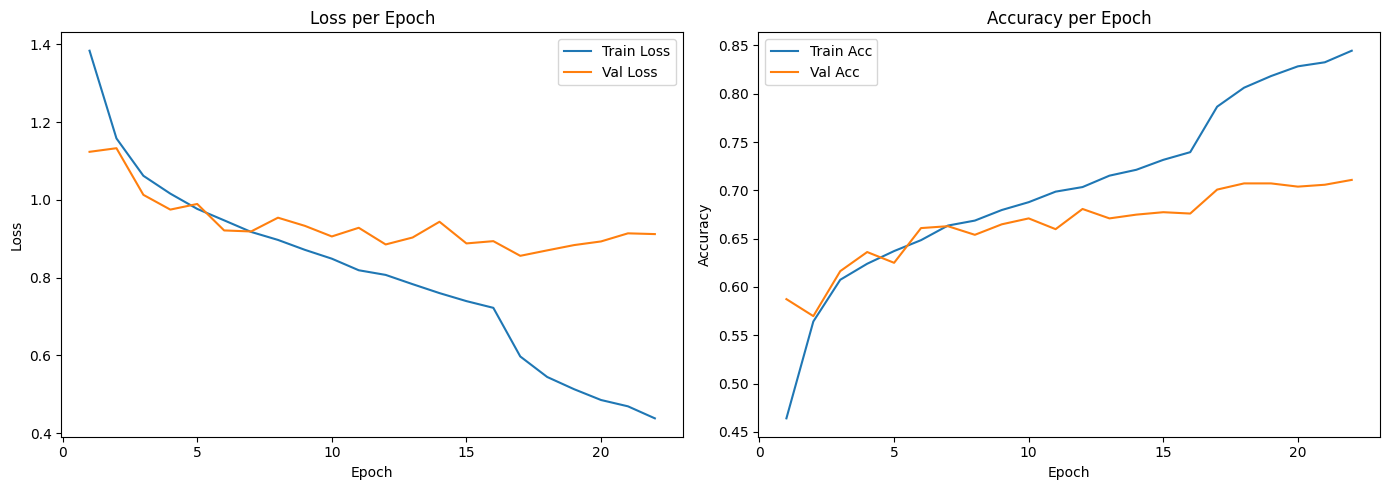

In [46]:
epochs = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


## Ma trận nhầm lẫn


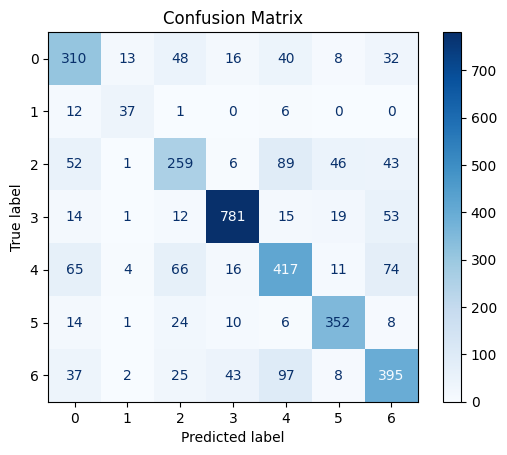

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Dự đoán trên tập validation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

## Predict ảnh sau khi test

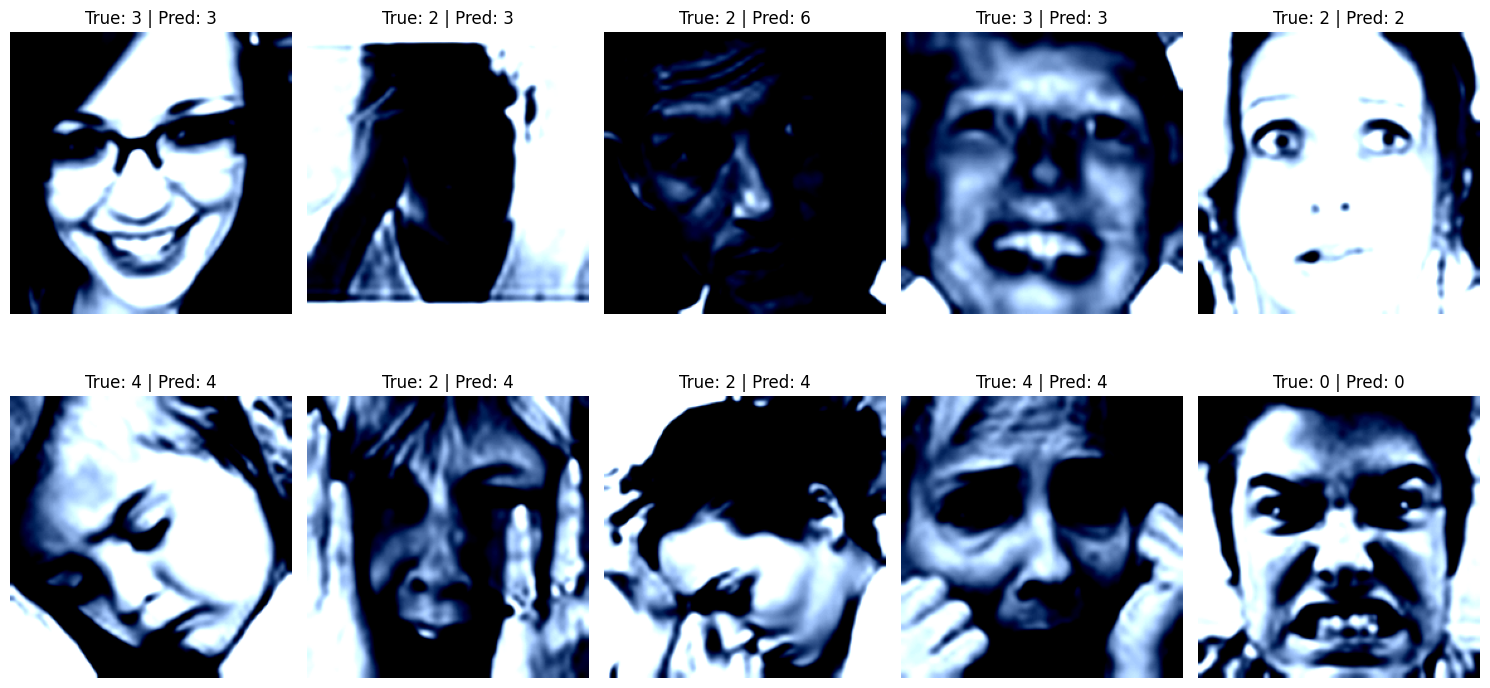

In [48]:
import matplotlib.pyplot as plt
import random

# Đặt mô hình về chế độ eval
model.eval()

# Lấy 1 batch từ val_loader
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Dự đoán
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Chọn ngẫu nhiên 10 ảnh
indices = random.sample(range(len(images)), 10)

# Hiển thị ảnh
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    image = images[idx].cpu().permute(1, 2, 0)  # từ (C, H, W) → (H, W, C)
    true_label = labels[idx].item()
    predicted_label = preds[idx].item()

    plt.subplot(2, 5, i+1)
    plt.imshow(image.squeeze(), cmap='gray' if image.shape[2] == 1 else None)
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Lưu model

In [49]:
torch.save(model.state_dict(),"Final_Project_DPL302m_EfficientNet_V2S_70acc.h5")
print(" Hoàn tất ")

 Hoàn tất 
